<a href="https://colab.research.google.com/github/remysealswarchild/Project-Ideas-And-Resources/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy tensorflow matplotlib seaborn opencv-python scikit-learn pandas onnxruntime scikit-image torch transformers pillow ipywidgets

In [5]:
# Traffic Signs detection:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import os, zipfile
import cv2
from sklearn.metrics import accuracy_score
import pandas as pd


import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
import requests
from PIL import Image as PILImage  # Use an alias to avoid conflict with matplotlib's Image
from io import BytesIO
import onnxruntime as ort
from skimage.transform import resize

# Imports for specific models/tasks
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from ipywidgets import interactive, FloatSlider
from IPython.display import display


TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

# Fetch images deom GTSRB website
# Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
# Images for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
# Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip


** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   314    0   314    0     0    251      0 --:--:--  0:00:01 --:--:--   251
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   314    0   314    0     0    615      0 --:--:-- --:--:-- --:--:--   616
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   314    0   314    0     0    604      0 --:--:-- --:--:-- --:--:--   603


In [6]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]

for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file, "r") as zip_ref:
        zip_ref.extractall(directory)


Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 12.8 s, sys: 8.58 s, total: 21.3 s
Wall time: 22.7 s


In [7]:
### Training dataset preparation
# The GTSRB dataset stores images as *.ppm files, which cannot be directly read by TensorFlow.
# Therefore, we convert them to .jpg so TensorFlow can process them.

# Collect all PPM files and their labels
tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [
    d for d in os.listdir(tmp_train_data_dir)
    if os.path.isdir(os.path.join(tmp_train_data_dir, d))
]

# Loop through the label directories and collect the data
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [
        os.path.join(label_dir, f)
        for f in os.listdir(label_dir)
        if f.endswith(".ppm")
    ]
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)

# Sort for consistency
ppm_files_train.sort()
ppm_labels_train.sort()


In [8]:
%%time
# Convert .ppm to .jpg in training set
for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = cv2.imread(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)

    cv2.imwrite(os.path.join(directory, image_filename), image)


CPU times: user 5.58 s, sys: 4.87 s, total: 10.5 s
Wall time: 10.9 s


In [9]:
## Prepare training, validation and labels
# Originally dataset uses numerical labels ("00000"); let's make them human-readable.

OUTPUT_ROOT_DIR = "output/"
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "labels_readable.txt")
label_map = {
    0: '20_speed', 1: '30_speed', 2: '50_speed', 3: '60_speed',
    4: '70_speed', 5: '80_speed', 6: '80_lifted', 7: '100_speed',
    8: '120_speed', 9: 'no_overtaking_general', 10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing', 12: 'right_of_way_general', 13: 'give_way',
    14: 'stop', 15: 'no_way_general', 16: 'no_way_trucks',
    17: 'no_way_one_way', 18: 'attention_general', 19: 'attention_left_turn',
    20: 'attention_right_turn', 21: 'attention_curvy', 22: 'attention_bumpers',
    23: 'attention_slippery', 24: 'attention_bottleneck',
    25: 'attention_construction', 26: 'attention_traffic_light',
    27: 'attention_pedestrian', 28: 'attention_children',
    29: 'attention_bikes', 30: 'attention_snowflake', 31: 'attention_deer',
    32: 'lifted_general', 33: 'turn_right', 34: 'turn_left',
    35: 'turn_straight', 36: 'turn_straight_right', 37: 'turn_straight_left',
    38: 'turn_right_down', 39: 'turn_left_down', 40: 'turn_circle',
    41: 'lifted_no_overtaking_general', 42: 'lifted_no_overtaking_trucks'
}
num_classes = len(label_map)

if not os.path.exists(OUTPUT_ROOT_DIR):
    os.makedirs(OUTPUT_ROOT_DIR)

with open(OUTPUT_READABLE_LABELS, 'w') as file:
    for key, val in sorted(label_map.items()):
        file.write(f"{val}\n")


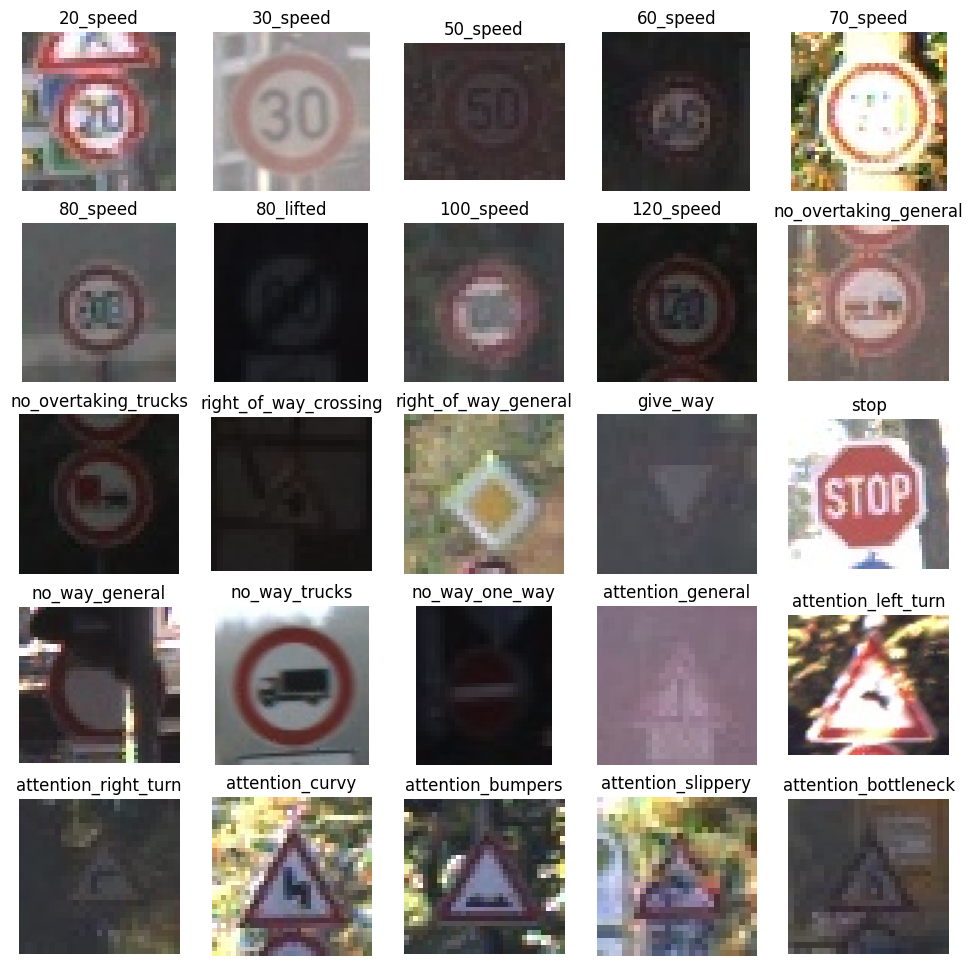

In [10]:
# Display example image for each category
preprocessed_training_dirs = [
    d for d in os.listdir(TRAINING_DATA_DIR)
    if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))
]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(
        os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg")
    )

plt.figure(figsize=(12, 12))
for i, image in enumerate(training_images):
    if i >= 25:
        break
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.title(f"{label_map[i]}")
    img = cv2.imread(image)[..., ::-1]
    plt.imshow(img)
plt.show()


In [11]:
## Training dataset preparation

# Define image shape and create generator
IMAGE_SHAPE = (128, 128)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# Batches from training directory
image_data = image_generator.flow_from_directory(
    str(TRAINING_DATA_DIR),
    target_size=IMAGE_SHAPE,
    batch_size=512
)

for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break


Found 39209 images belonging to 43 classes.
Image batch shape:  (512, 128, 128, 3)
Label batch shape:  (512, 43)


In [12]:
## Validation dataset preparation
# Convert validation *.ppm to *.jpg
import time

start_time = time.time()

tmp_validation_data_dir = os.path.join(
    TMP_DATA_DIR, "GTSRB/Final_Test/Images"
)

#%%time
tmp_validation_data_files = [
    f for f in os.listdir(tmp_validation_data_dir)
    if f.endswith(".ppm")
]

validation_images = []
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file)
    image = cv2.imread(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = f"{os.path.splitext(ppm_file)[0]}.jpg"

    if not os.path.exists(directory):
        os.makedirs(directory)

    final_image = os.path.join(directory, image_filename)
    cv2.imwrite(final_image, image)
    validation_images.append(final_image)

validation_images.sort()
print("Validation images count:", len(validation_images))
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")


Validation images count: 12630
Execution time: 3.18 seconds


In [13]:
# Build and compile model
model = Sequential([
    Input(shape=(128,128,3)),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPool2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"]
)

predictions = model(image_batch)  # do prediction on batch
predictions.shape               # check the shape of predictions


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,489,291 (17.13 MB)

 Trainable params: 4,488,139 (17.12 MB)

 Non-trainable params: 1,152 (4.50 KB)

TensorShape([512, 43])

In [ ]:
# Custom callback to collect batch stats
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics()

steps_per_epoch = int(np.ceil(image_data.samples / image_data.batch_size))
batch_stats_callback = CollectBatchStats()

history = model.fit(
    image_data,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback]
)

# Plot training loss
plt.figure()
plt.plot(batch_stats_callback.batch_losses)
plt.ylim([0,2])
plt.ylabel("Loss")
plt.xlabel("Training Steps")

# Plot training accuracy
plt.figure()
plt.plot(batch_stats_callback.batch_acc)
plt.ylim([0,1])
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 6076s 79s/step - accuracy: 0.6836 - loss: 1.2012
Epoch 2/5
36/77 ━━━━━━━━━━━━━━━━━━━━ 53:49 79s/step - accuracy: 0.9530 - loss: 0.2363

In [14]:
# Validation evaluation
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
val_data_frame = pd.read_csv(tmp_validation_labels_csv, header=0, sep=';')

val_data_frame['Filename'] = val_data_frame['Filename'].str.replace('.ppm', '.jpg')
val_data_frame['ClassId'] = val_data_frame['ClassId'].astype(str).str.zfill(5)

image_val_data = image_generator.flow_from_dataframe(
    val_data_frame,
    x_col="Filename",
    directory=VALIDATION_DATA_DIR,
    y_col="ClassId",
    target_size=IMAGE_SHAPE
)

for image_val_batch, label_val_batch in image_val_data:
    print("Image batch shape: ", image_val_batch.shape)
    print("Label batch shape: ", label_val_batch.shape)
    break


Found 12630 validated image filenames belonging to 43 classes.
Image batch shape:  (32, 128, 128, 3)
Label batch shape:  (32, 43)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


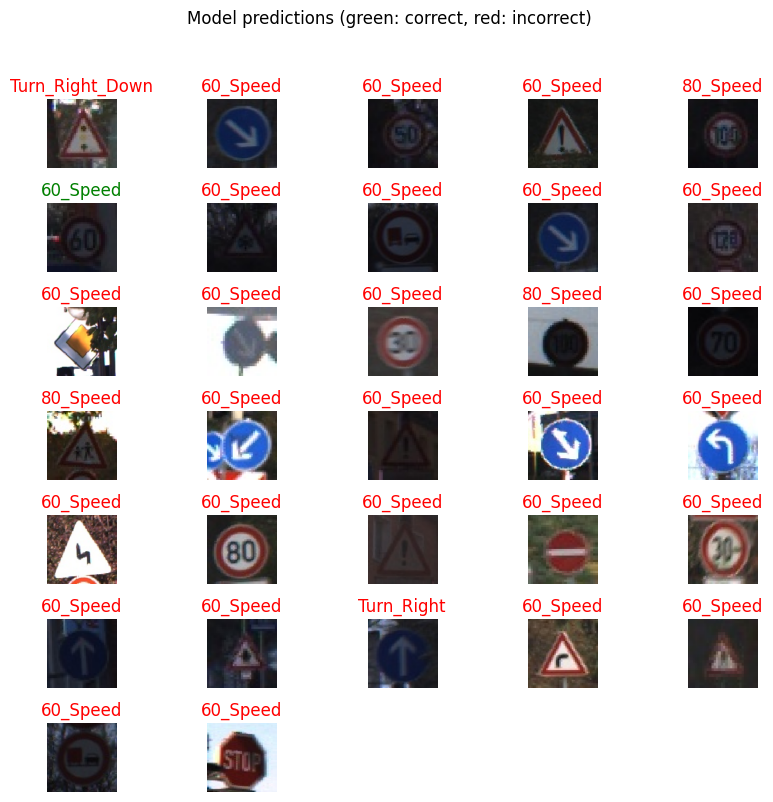

Accuracy of the shown eval batch:
0.03125


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ━━━━━━━━━━━━━━━━━━━━ 410s 1s/step - accuracy: 0.0416 - loss: 3.9913
Loss: 3.993656635284424 Accuracy: 0.039657361805438995


In [15]:
# Predict and plot a validation batch
predicted_batch = model.predict(image_val_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_val_batch, axis=-1)

batch_size = image_val_batch.shape[0]
num_plot_column = 5
num_plot_row = batch_size // num_plot_column + (batch_size % num_plot_column > 0)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(batch_size):
    plt.subplot(num_plot_row, num_plot_column, n+1)
    plt.imshow(image_val_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(label_map[predicted_id[n]].title(), color=color)
    plt.axis('off')
plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

print("Accuracy of the shown eval batch:")
print(accuracy_score(label_id, predicted_id))

score = model.evaluate(
    x=image_val_data,
    batch_size=image_val_data.batch_size,
    steps=int(image_val_data.samples / image_val_data.batch_size)
)
print("Loss:", score[0], "Accuracy:", score[1])


# MultiModal Learning Lab

Welcome! This notebook provides hands-on experience with MultiModal Learning concepts using deep learning methods. We'll focus on using pre-trained models to demonstrate key concepts efficiently, without requiring extensive model training time.

**Multimodal Learning** involves designing AI models that can process and relate information from multiple types of data (modalities), such as images, text, audio, and depth information. This often leads to a more robust and comprehensive understanding of the world compared to using a single modality alone.

## Topics Covered
- **Deep Learning-based Depth Estimation:** Using an image (RGB) to predict the distance of objects (Depth).
- **3D Model Creation from RGB-Depth Fusion:** Combining image color with estimated depth to create a 3D representation (Point Cloud).
- **MultiModal Object Detection:** Using both image data and depth estimation to detect objects (like people) and estimate their distance.
- **Image-to-Text Captioning:** Generating textual descriptions from images, bridging vision and language.

Let's start by installing the necessary libraries.


# Install required packages
!pip install numpy matplotlib opencv-python scikit-image onnx onnxruntime transformers torch pillow ipywidgets


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
import requests
from PIL import Image as PILImage  # Use an alias to avoid conflict with matplotlib's Image
from io import BytesIO
import onnxruntime as ort
from skimage.transform import resize

# Imports for specific models/tasks
import torch
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from ipywidgets import interactive, FloatSlider
from IPython.display import display

# Create directories for our data and models
os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Set up plotting style and display plots inline
plt.style.use('ggplot')
%matplotlib inline

# Download MiDaS model (ONNX format) if not already downloaded
midas_model_path = "models/midas_small.onnx"
if not os.path.exists(midas_model_path):
    print(f"Downloading MiDaS model to {midas_model_path}...")
    midas_url = "https://github.com/isl-org/MiDaS/releases/download/v2_1/model-small.onnx"
    urllib.request.urlretrieve(midas_url, midas_model_path)
    print("MiDaS model download complete!")
else:
    print("MiDaS model already exists.")

# Download family room image if not already downloaded
family_room_path = "data/images/family_room.jpg"
if not os.path.exists(family_room_path):
    print(f"Downloading family room image to {family_room_path}...")
    family_room_url = "https://upload.wikimedia.org/wikipedia/commons/7/75/Family-room-700.jpg"
    urllib.request.urlretrieve(family_room_url, family_room_path)
    print("Family room image download complete!")
else:
    print("Family room image already exists.")


MiDaS model download complete!
Family room image download complete!


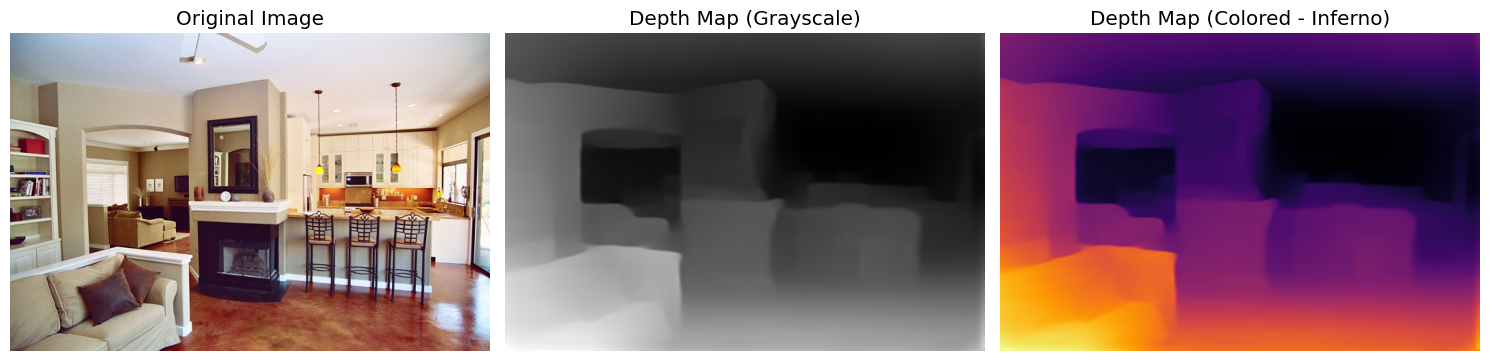

Observe the depth maps:
- In the grayscale map, brighter areas (like the foreground sofa) are closer.
- In the colored map (Inferno), yellow/white areas are closer, dark purple/black areas are farther.


In [17]:
def estimate_depth_midas(image_path, model_path):
    """
    Estimates depth from a single RGB image using a pre-trained MiDaS ONNX model.
    """
    img_bgr = cv2.imread(image_path)
    original_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    ort_session = ort.InferenceSession(model_path)
    input_name = ort_session.get_inputs()[0].name

    # Preprocess
    img_input = cv2.resize(original_img, (256, 256))
    img_input = img_input.astype(np.float32) / 255.0
    img_input = img_input.transpose(2, 0, 1)
    img_input = np.expand_dims(img_input, axis=0)

    # Inference
    outputs = ort_session.run(None, {input_name: img_input})
    depth_prediction = outputs[0].squeeze()

    # Post-process
    depth_resized = cv2.resize(depth_prediction, (original_img.shape[1], original_img.shape[0]))
    depth_min, depth_max = depth_resized.min(), depth_resized.max()
    if depth_max - depth_min > 1e-6:
        depth_normalized = 255 * (depth_resized - depth_min) / (depth_max - depth_min)
    else:
        depth_normalized = np.zeros_like(depth_resized)
    depth_uint8 = depth_normalized.astype(np.uint8)
    depth_colored = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_INFERNO)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

    return original_img, depth_resized, depth_colored

# Estimate depth and visualize
img_family, depth_map_family, depth_colored_family = estimate_depth_midas(
    family_room_path, midas_model_path
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_family); plt.title('Original Image'); plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(depth_map_family, cmap='gray'); plt.title('Depth Map (Grayscale)'); plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(depth_colored_family); plt.title('Depth Map (Colored - Inferno)'); plt.axis('off')
plt.tight_layout(); plt.show()

print("Observe the depth maps:")
print("- In the grayscale map, brighter areas (like the foreground sofa) are closer.")
print("- In the colored map (Inferno), yellow/white areas are closer, dark purple/black areas are farther.")


In [18]:
# Download Oxford Street image if not already downloaded
oxford_street_path = "data/images/oxford_street.jpg"
if not os.path.exists(oxford_street_path):
    print(f"Downloading Oxford Street image to {oxford_street_path}...")
    # Using a direct link that's less likely to change
    oxford_street_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Oxford.street.london.arp.jpg/1529px-Oxford.street.london.arp.jpg"  # Using a different standard image for reliability
    try:
        urllib.request.urlretrieve(oxford_street_url, oxford_street_path)
        print("Image download complete!")
    except Exception as e:
        print(f"Error downloading image: {e}. Please provide a valid URL or upload the image manually.")
else:
    print("Oxford Street image already exists.")

# Download YOLOv3 model files (weights, config, class names)
yolo_weights_path = "models/yolov3.weights"
yolo_config_path = "models/yolov3.cfg"
coco_names_path = "models/coco.names"

# Weights file (large, might take time)
if not os.path.exists(yolo_weights_path):
    print(f"Downloading YOLOv3 weights to {yolo_weights_path}...")
    # Using a common source for YOLOv3 weights
    yolo_weights_url = "https://huggingface.co/spaces/Epitech/Scarecrow/resolve/main/yolov3.weights"
    try:
        urllib.request.urlretrieve(yolo_weights_url, yolo_weights_path)
        print("YOLOv3 weights download complete!")
    except Exception as e:
        print(f"Error downloading weights: {e}. Check URL or download manually.")
else:
    print("YOLOv3 weights already exist.")

# Configuration file
if not os.path.exists(yolo_config_path):
    print(f"Downloading YOLOv3 config to {yolo_config_path}...")
    yolo_config_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
    try:
        urllib.request.urlretrieve(yolo_config_url, yolo_config_path)
        print("YOLOv3 config download complete!")
    except Exception as e:
        print(f"Error downloading config: {e}. Check URL or download manually.")
else:
    print("YOLOv3 config already exists.")

# COCO class names file
if not os.path.exists(coco_names_path):
    print(f"Downloading COCO class names to {coco_names_path}...")
    coco_names_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"
    try:
        urllib.request.urlretrieve(coco_names_url, coco_names_path)
        print("COCO names download complete!")
    except Exception as e:
        print(f"Error downloading names: {e}. Check URL or download manually.")
else:
    print("COCO class names already exist.")

Image download complete!
YOLOv3 weights download complete!
YOLOv3 config download complete!
COCO names download complete!


In [21]:
def detect_people_and_estimate_depth(image_path, depth_model_path, yolo_weights_path, yolo_config_path, coco_names_path,
                                       yolo_input_size=608, conf_threshold=0.5, nms_threshold=0.4, depth_scale_factor=10.0):
    """
    Detects people in an image using YOLOv3, estimates their depth using MiDaS,
    and returns annotated images and depth data.

    Args:
        image_path (str): Path to the input image.
        depth_model_path (str): Path to the MiDaS ONNX model.
        yolo_weights_path (str): Path to YOLOv3 weights.
        yolo_config_path (str): Path to YOLOv3 config.
        coco_names_path (str): Path to COCO class names file.
        yolo_input_size (int): Input size for YOLO (e.g., 416, 608). Larger sizes might detect smaller objects better.
        conf_threshold (float): Confidence threshold for YOLO detections.
        nms_threshold (float): Non-Maximum Suppression threshold.
        depth_scale_factor (float): Arbitrary factor for scaling depth value to 'meters' for display.
                                    This is NOT metrically accurate, just for visualization.

    Returns:
        tuple:
            - result_img (np.array): Image with bounding boxes, depth estimates, and count.
            - depth_viz_with_boxes (np.array): Colored depth map with bounding boxes.
            - person_count (int): Number of people detected after NMS.
            - person_depths_meters (list): List of estimated depths (in approximate 'meters') for detected people.
    """
    # --- 1. Estimate Depth ---
    # depth_map contains the resized raw (relative inverse) depth values
    img, depth_map, depth_colored = estimate_depth_midas(image_path, depth_model_path)
    height, width = img.shape[:2]

    # --- Calculate depth range for normalization (do this once) ---
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    depth_range = depth_max - depth_min
    # Add a small epsilon to avoid division by zero if the range is tiny
    depth_range = depth_range if depth_range > 1e-6 else 1e-6

    # --- 2. Load YOLO Model ---
    try:
        net = cv2.dnn.readNetFromDarknet(yolo_config_path, yolo_weights_path)
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
        with open(coco_names_path, 'r') as f:
            classes = [line.strip() for line in f.readlines()]
            person_class_id = classes.index('person')
    except Exception as e:
        print(f"Error loading YOLO model: {e}. Ensure paths are correct and files are downloaded.")
        error_img = img.copy()
        cv2.putText(error_img, "YOLO Load Error", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        return error_img, depth_colored.copy(), 0, []

    # --- 3. Prepare Image for YOLO and Detect Objects ---
    img_bgr_for_yolo = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    blob = cv2.dnn.blobFromImage(img_bgr_for_yolo, 1/255.0, (yolo_input_size, yolo_input_size), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)

    # --- 4. Process Detections & Apply NMS ---
    class_ids = []
    confidences = []
    boxes = []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if class_id == person_class_id and confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                if w > 200 : # Ignore large bounding boxes (likely false positives)
                    continue
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    indices = indices.flatten() if len(indices) > 0 else []

    # --- 5. Annotate Image and Extract Depths ---
    result_img = img.copy()
    depth_viz_with_boxes = depth_colored.copy()
    person_count = len(indices)
    person_depths_meters = []
   # person_centers = []
    for i in indices:
        x, y, w, h = boxes[i]
        x1, y1 = max(0, x), max(0, y)
        x2, y2 = min(width - 1, x + w), min(height - 1, y + h)
        box_w, box_h = x2 - x1, y2 - y1

        center_x, center_y = x1 + box_w // 2, y1 + box_h // 2
        # Clip coordinates just in case (shouldn't be necessary with max/min above)
        center_y = np.clip(center_y, 0, height - 1)
        center_x = np.clip(center_x, 0, width - 1)
       # person_centers.append((center_x, center_y))
        # Get the raw (relative inverse) depth value from the depth_map
        inverse_depth_value = depth_map[center_y, center_x]

         # --- Approximate Depth Conversion (using available depth_map) ---
        # Normalize the inverse depth value to the [0, 255] range based on the *entire map's* min/max
        # This replicates the normalization step that created the uint8 map used for coloring
        normalized_uint8_equivalent = 255 * (inverse_depth_value - depth_min) / depth_range
        # Ensure the value is within [0, 255] after normalization
        normalized_uint8_equivalent = np.clip(normalized_uint8_equivalent, 0, 255)

        # Apply arbitrary scaling: Higher uint8 value (closer inverse depth) -> smaller meters
        depth_meters = (255 - normalized_uint8_equivalent) / depth_scale_factor
        person_depths_meters.append(depth_meters)
        # --- End Approximate Conversion ---

        confidence = confidences[i]
        color_factor = min(1.0, max(0.0, depth_meters / 30.0)) # Normalize to 0-1 for coloring
        color = (int(255 * (1 - color_factor)), 0, int(255 * color_factor)) # RGB

        cv2.rectangle(result_img, (x1, y1), (x2, y2), color, 2)
        cv2.rectangle(depth_viz_with_boxes, (x1, y1), (x2, y2), color, 2)

        label = f"P{i}: {confidence:.2f}"
        depth_label = f"{depth_meters:.1f}m (Est.)"
        cv2.putText(result_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.putText(result_img, depth_label, (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    count_text = f"Detected People: {person_count}"
    cv2.putText(result_img, count_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    return result_img, depth_viz_with_boxes, person_count, person_depths_meters, # person_centers

Running detection and depth estimation on: data/images/oxford_street.jpg
Detection complete. Found 32 people.


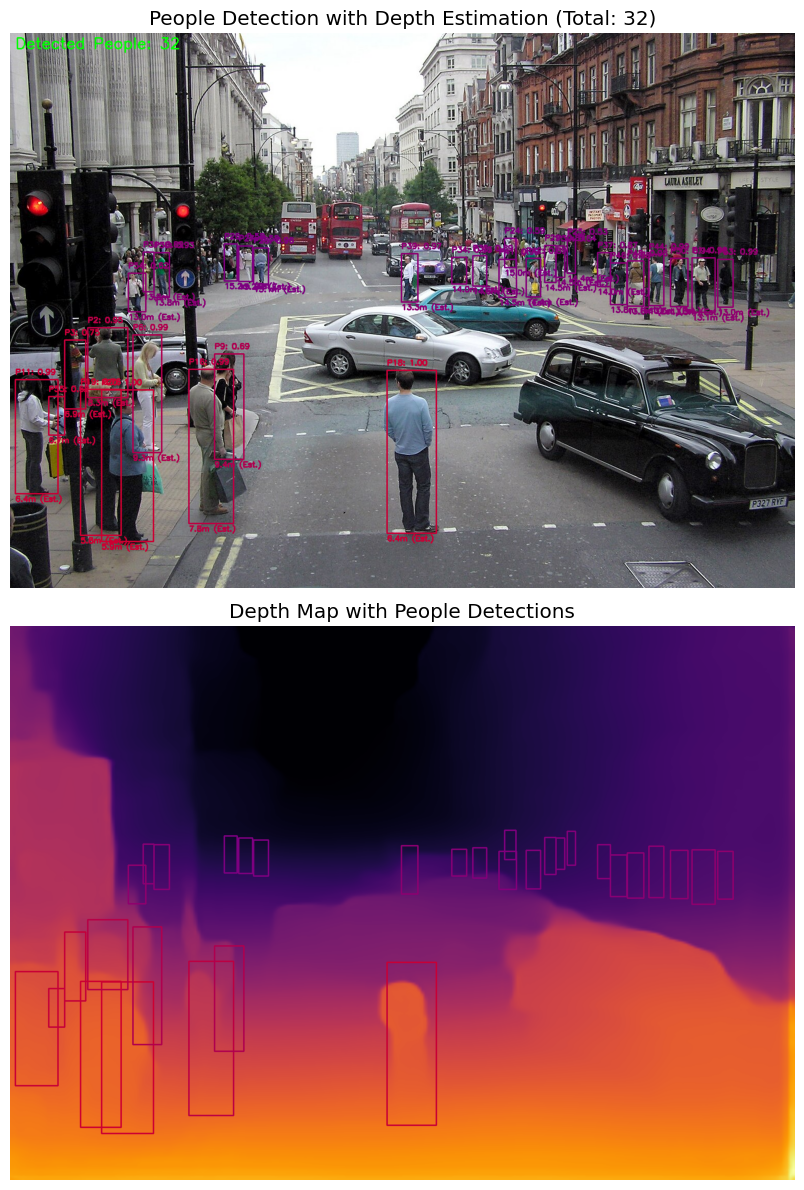

In [22]:
# --- Run Detection and Depth Estimation ONCE ---
# Check if the necessary model files exist before running
if os.path.exists(yolo_weights_path) and os.path.exists(yolo_config_path) and os.path.exists(coco_names_path) and os.path.exists(midas_model_path):
    print(f"Running detection and depth estimation on: {oxford_street_path}")
    # Using a slightly lower confidence threshold and adjusted NMS might help in crowded scenes
    result_img_oxford, depth_viz_oxford, person_count_oxford, person_depths_oxford = detect_people_and_estimate_depth(
        oxford_street_path,
        midas_model_path,
        yolo_weights_path,
        yolo_config_path,
        coco_names_path,
        yolo_input_size=608,      # Larger input size for potentially better small object detection
        conf_threshold=0.5,     # Standard confidence threshold
        nms_threshold=0.4,      # Standard NMS threshold
        depth_scale_factor=15.0 # Adjust this scaling factor based on scene/visualization preference
    )
    print(f"Detection complete. Found {person_count_oxford} people.")

    # --- Display the detection results ---
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 1, 1)
    plt.imshow(result_img_oxford)
    plt.title(f'People Detection with Depth Estimation (Total: {person_count_oxford})')
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.imshow(depth_viz_oxford)
    plt.title('Depth Map with People Detections')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Error: One or more model files (YOLO weights/config/names or MiDaS) not found. Cannot run detection.")
    # Assign dummy values to avoid errors in the next cell if files are missing
    person_depths_oxford = []
    person_count_oxford = 0

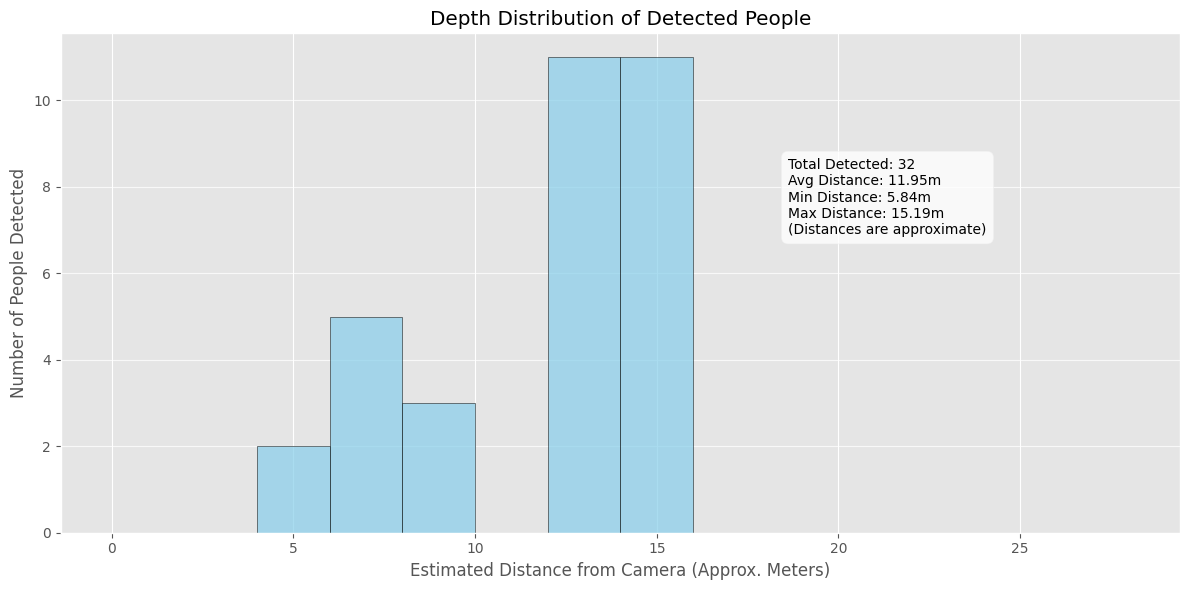

In [23]:
# --- Analyze Depth Distribution using stored results ---

# Check if we have depth data to plot
if person_depths_oxford:
    # Create histogram of the estimated person depths
    plt.figure(figsize=(12, 6))

    # Define bins for the histogram (e.g., 0-50 meters in 2-meter intervals)
    max_dist = max(person_depths_oxford) if person_depths_oxford else 30
    bins = np.arange(0, max(30, np.ceil(max_dist) + 2), 2)

    plt.hist(person_depths_oxford, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

    # Add labels and title
    plt.xlabel('Estimated Distance from Camera (Approx. Meters)')
    plt.ylabel('Number of People Detected')
    plt.title('Depth Distribution of Detected People')
    plt.grid(axis='y', alpha=0.75)

    # Add text with summary statistics
    mean_depth = np.mean(person_depths_oxford)
    min_depth = min(person_depths_oxford)
    max_depth = max(person_depths_oxford)
    stats_text = (f'Total Detected: {person_count_oxford}\n'
                  f'Avg Distance: {mean_depth:.2f}m\n'
                  f'Min Distance: {min_depth:.2f}m\n'
                  f'Max Distance: {max_depth:.2f}m\n'
                  f'(Distances are approximate)')

    # Place text box on the plot
    plt.text(0.65, 0.75, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

    plt.tight_layout()
    plt.show()
else:
    print("No person depth data available to plot histogram (detection might have failed or found no people).")

In [25]:
# Define image URLs and local paths
image_info = {
    "basketball": {
        "url": "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/basketball1.png", # Using a different standard image
        "path": "data/images/basketball.jpg"
    },
    "fruits": {
        "url": "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/fruits.jpg", # Using a different standard image
        "path": "data/images/fruits.jpg"
    },
    "family_room": {
        "path": family_room_path # Reuse path from earlier
    },
    "oxford_street": {
        "path": oxford_street_path # Reuse path from earlier
    }
}

image_paths_for_captioning = []

# Download images if they don't exist
for name, info in image_info.items():
    path = info['path']
    image_paths_for_captioning.append(path)
    if 'url' in info and not os.path.exists(path):
        print(f"Downloading image for '{name}' to {path}...")
        try:
            urllib.request.urlretrieve(info['url'], path)
            print("Download complete!")
        except Exception as e:
            print(f"Error downloading {name} image: {e}. Skipping this image.")
            image_paths_for_captioning.remove(path) # Remove if download failed
    elif not os.path.exists(path):
         print(f"Image path for '{name}' ({path}) does not exist and no URL provided. Skipping.")
         if path in image_paths_for_captioning: image_paths_for_captioning.remove(path)
    else:
        print(f"Image for '{name}' ({path}) already exists.")

print(f"\nUsing images: {image_paths_for_captioning}")

Download complete!
Download complete!
Image for 'family_room' (data/images/family_room.jpg) already exists.
Image for 'oxford_street' (data/images/oxford_street.jpg) already exists.

Using images: ['data/images/basketball.jpg', 'data/images/fruits.jpg', 'data/images/family_room.jpg', 'data/images/oxford_street.jpg']


In [29]:
def load_visiongpt2_model(model_name="nlpconnect/vit-gpt2-image-captioning"):
    """
    Loads the pre-trained Vision Transformer (ViT) + GPT-2 image captioning model,
    its associated image processor, and tokenizer from Hugging Face.

    Args:
        model_name (str): The name of the model on Hugging Face Hub.

    Returns:
        tuple: (model, feature_extractor, tokenizer, device)
    """
    print(f"Loading VisionGPT-2 model ('{model_name}')...")
    try:
        model = VisionEncoderDecoderModel.from_pretrained(model_name)
        feature_extractor = ViTImageProcessor.from_pretrained(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    except Exception as e:
        print(f"Error loading model components: {e}")
        print("Please ensure you have an internet connection and the model name is correct.")
        return None, None, None, None

    # Set the device (use GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Model loaded successfully. Using device: {device}")
    return model, feature_extractor, tokenizer, device

def generate_captions_visiongpt2(image_paths, model, feature_extractor, tokenizer, device):
    """
    Generates captions for a list of images using the loaded VisionGPT-2 model.

    Args:
        image_paths (list): List of paths to input images.
        model: The loaded VisionEncoderDecoderModel.
        feature_extractor: The loaded ViTImageProcessor.
        tokenizer: The loaded AutoTokenizer.
        device: The torch device (CPU or CUDA) to run inference on.

    Returns:
        list: A list of generated captions corresponding to the input images.
    """
    if not all([model, feature_extractor, tokenizer, device]):
        print("Model components not loaded correctly. Cannot generate captions.")
        return ["Error"] * len(image_paths)

    # --- Generation Parameters ---
    # max_length controls the maximum number of words in the caption.
    # num_beams uses beam search for potentially better (but slower) generation.
    # Changed num_beams to 1 to avoid NotImplementedError with this model architecture/transformers version
    max_length = 16
    num_beams = 1 # Changed from 4 to 1
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}


    # --- Load and Process Images ---
    images = []
    valid_image_paths = []
    print("Processing images...")
    for image_path in image_paths:
        try:
            i_image = PILImage.open(image_path)
            # Ensure image is in RGB format
            if i_image.mode != "RGB":
                i_image = i_image.convert(mode="RGB")
            images.append(i_image)
            valid_image_paths.append(image_path) # Keep track of successfully loaded images
        except Exception as e:
            print(f"Error opening or processing image {image_path}: {e}. Skipping.")

    if not images:
        print("No valid images to process.")
        return []

    # --- Feature Extraction ---
    # Use the feature extractor (ViTImageProcessor) to prepare images for the model
    # This typically involves resizing, normalization, and converting to tensors.
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    # Move tensor to the appropriate device (CPU/GPU)
    pixel_values = pixel_values.to(device)

    # --- Caption Generation ---
    print("Generating captions...")
    # Generate token IDs using the model
    with torch.no_grad(): # Disable gradient calculation for efficiency during inference
      output_ids = model.generate(pixel_values, **gen_kwargs)

    # --- Decoding ---
    # Decode the generated token IDs back into text using the tokenizer
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    # Clean up whitespace
    preds = [pred.strip() for pred in preds]
    print("Caption generation complete.")

    # Create a dictionary mapping original path to caption for clarity
    captions_map = {path: caption for path, caption in zip(valid_image_paths, preds)}

    # Return captions in the order of the *original* image_paths list, inserting errors for skipped images
    final_captions = [captions_map.get(path, "Error loading image") for path in image_paths]

    return final_captions

In [27]:
# Load the VisionGPT-2 model and associated components
caption_model, feature_extractor, tokenizer, device = load_visiongpt2_model()

Loading VisionGPT-2 model ('nlpconnect/vit-gpt2-image-captioning')...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Model loaded successfully. Using device: cpu


Processing images...
Generating captions...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.


Caption generation complete.


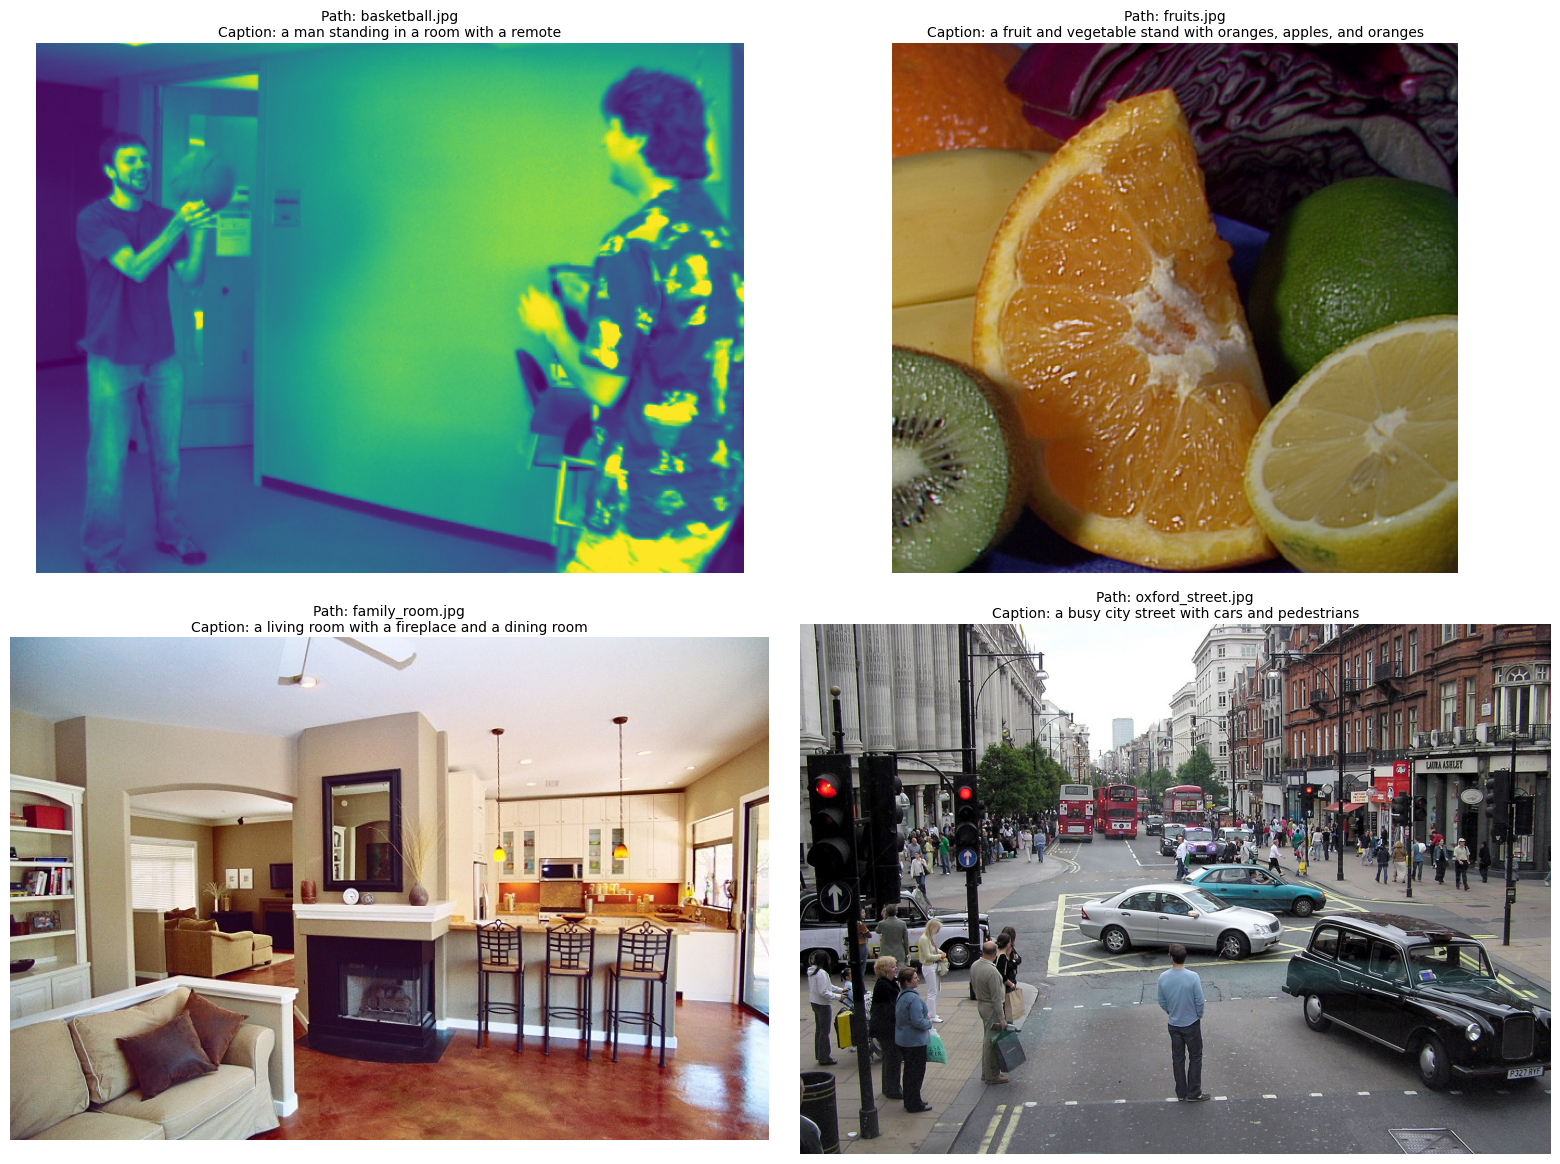

In [30]:
# Generate captions for the selected images
# Ensure the model loaded correctly before proceeding
if caption_model:
    captions = generate_captions_visiongpt2(image_paths_for_captioning, caption_model, feature_extractor, tokenizer, device)
else:
    captions = ["Model Load Failed"] * len(image_paths_for_captioning)

# Display the images with their generated captions
# Determine grid size dynamically
num_images = len(image_paths_for_captioning)
if num_images > 0:
    cols = 2
    rows = (num_images + cols - 1) // cols # Calculate rows needed
    plt.figure(figsize=(8 * cols, 6 * rows))

    for i, (image_path, caption) in enumerate(zip(image_paths_for_captioning, captions)):
        plt.subplot(rows, cols, i + 1)
        try:
            img = PILImage.open(image_path)
            plt.imshow(img)
            # Wrap title text for better display
            title_text = f'Path: {os.path.basename(image_path)}\nCaption: {caption}'
            plt.title(title_text, wrap=True, fontsize=10)
        except FileNotFoundError:
            plt.title(f'Image not found:\n{os.path.basename(image_path)}', fontsize=10)
            # Optionally display a placeholder or leave blank
            plt.gca().set_facecolor('lightgray')
        except Exception as e:
             plt.title(f'Error loading:\n{os.path.basename(image_path)}\n{e}', fontsize=10)
        plt.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()
else:
    print("No images were available for captioning.")